# Alignment Error Visualization

This notebook collects COM data from the database and tries to quantify some alignment errors. The main results are shown in the plots at the end of the notebook.

In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from sqlalchemy import func

sns.set_style("whitegrid")

PIPELINE_ROOT = Path('.').absolute().parents[2]
sys.path.append(PIPELINE_ROOT.as_posix())
from utilities.model.center_of_mass import CenterOfMass
from utilities.model.structure import Structure
from sql_setup import session

In [2]:
# configurations for brains
brains_to_extract_common_structures = ['DK39', 'DK41', 'DK43', 'DK54', 'DK55']
brains_to_examine = ['DK39', 'DK41', 'DK43', 'DK52', 'DK54', 'DK55']

## Data Collection

In [3]:
def query_brain_coms(brain, person_id=28, input_type_id=4):
    # default: person is bili, input_type is aligned
    rows = session.query(CenterOfMass)\
        .filter(CenterOfMass.active.is_(True))\
        .filter(CenterOfMass.prep_id == brain)\
        .filter(CenterOfMass.person_id == person_id)\
        .filter(CenterOfMass.input_type_id == input_type_id)\
        .all()
    row_dict = {}
    for row in rows:
        structure = row.structure.abbreviation
        row_dict[structure] = np.array([row.x, row.y, row.section])
    return row_dict

In [4]:
from utilities.sqlcontroller import SqlController

def get_atlas_centers(
        atlas_box_size=(1000, 1000, 300),
        atlas_box_scales=(10, 10, 20),
        atlas_raw_scale=10
):
    atlas_box_scales = np.array(atlas_box_scales)
    atlas_box_size = np.array(atlas_box_size)
    atlas_box_center = atlas_box_size / 2
    sqlController = SqlController('Atlas')
    # person is lauren, input_type is manual
    atlas_centers = sqlController.get_centers_dict('Atlas', input_type_id=1, person_id=16)

    for structure, center in atlas_centers.items():
        # transform into the atlas box coordinates that neuroglancer assumes
        center = atlas_box_center + np.array(center) * atlas_raw_scale / atlas_box_scales
        atlas_centers[structure] = center

    return atlas_centers

atlas_coms = get_atlas_centers()

No histology for Atlas
No scan run for Atlas


In [5]:
common_structures = set()
for brain in brains_to_extract_common_structures:
    common_structures = common_structures | set(query_brain_coms(brain).keys())
common_structures = list(sorted(common_structures))
common_structures

['10N_L',
 '10N_R',
 '3N_L',
 '3N_R',
 '4N_L',
 '4N_R',
 '5N_L',
 '5N_R',
 '6N_L',
 '6N_R',
 '7N_L',
 '7N_R',
 'DC_L',
 'DC_R',
 'LC_L',
 'LC_R',
 'LRt_L',
 'LRt_R',
 'Pn_L',
 'Pn_R',
 'SC',
 'Tz_L',
 'Tz_R']

In [6]:
def prepare_table(brains, person_id, input_type_id, save_path):
    df_save = prepare_table_for_save(
        brains,
        person_id=person_id,
        input_type_id=input_type_id
    )
    df_save.to_csv(save_path, index=False)
    
    df = prepare_table_for_plot(
        brains,
        person_id=person_id,
        input_type_id=input_type_id
    )

    return df_save, df

def get_brain_coms(brains, person_id, input_type_id):
    brain_coms = {}
    for brain in brains:
        brain_coms[brain] = query_brain_coms(
            brain,
            person_id=person_id,
            input_type_id=input_type_id
        )
        # A temporary hack: for ('DK55', corrected), use ('DK55', aligned)
        if (brain, input_type_id) == ('DK55', 2):
            brain_coms[brain] = query_brain_coms(
                brain,
                person_id=person_id,
                input_type_id=4
            )
    return brain_coms

def prepare_table_for_save(brains, person_id, input_type_id):
    brain_coms = get_brain_coms(brains, person_id, input_type_id)

    data = {}
    data['name'] = []
    for s in common_structures:
        for c in ['dx', 'dy', 'dz', 'dist']:
            data['name'] += [f'{s}_{c}']
    for brain in brain_coms.keys():
        data[brain] = []
        offset = [brain_coms[brain][s] - atlas_coms[s]
                  if s in brain_coms[brain] else [np.nan, np.nan, np.nan]
                  for s in common_structures]
        offset = np.array(offset)
        scale = np.array([10, 10, 20])
        dx, dy, dz = (offset * scale).T
        dist = np.sqrt(dx * dx + dy * dy + dz * dz)
        for dx_i, dy_i, dz_i, dist_i in zip(dx, dy, dz, dist):
            data[brain] += [dx_i, dy_i, dz_i, dist_i]
    df = pd.DataFrame(data)

    return df

def prepare_table_for_plot(brains, person_id, input_type_id):
    brain_coms = get_brain_coms(brains, person_id, input_type_id)

    df = pd.DataFrame()
    for brain in brain_coms.keys():
        offset = [brain_coms[brain][s] - atlas_coms[s]
                  if s in brain_coms[brain] else [np.nan, np.nan, np.nan]
                  for s in common_structures]
        offset = np.array(offset)
        scale = np.array([10, 10, 20])
        dx, dy, dz = (offset * scale).T
        dist = np.sqrt(dx * dx + dy * dy + dz * dz)

        df_brain = pd.DataFrame()

        data = {}
        data['structure'] = common_structures
        data['value'] = dx
        data['type'] = 'dx'
        df_brain = df_brain.append(pd.DataFrame(data), ignore_index=True)

        data = {}
        data['structure'] = common_structures
        data['value'] = dy
        data['type'] = 'dy'
        df_brain = df_brain.append(pd.DataFrame(data), ignore_index=True)

        data = {}
        data['structure'] = common_structures
        data['value'] = dz
        data['type'] = 'dz'
        df_brain = df_brain.append(pd.DataFrame(data), ignore_index=True)

        data = {}
        data['structure'] = common_structures
        data['value'] = dist
        data['type'] = 'dist'
        df_brain = df_brain.append(pd.DataFrame(data), ignore_index=True)

        df_brain['brain'] = brain
        df = df.append(df_brain, ignore_index=True)
    return df

In [7]:
def plot(df, ymin, ymax, ystep, title):
    fig, ax = plt.subplots(2, 1, figsize=(16, 12), dpi=200)
    
    sns.boxplot(ax=ax[0], x="structure", y="value", hue="type", data=df)
    ax[0].xaxis.grid(True)
    ax[0].set_xlabel('Structure')
    ax[0].set_ylabel('um')
    ax[0].set_title('full dynamic range')
    
    sns.boxplot(ax=ax[1], x="structure", y="value", hue="type", data=df)
    ax[1].xaxis.grid(True)
    ax[1].set_ylim(ymin, ymax)
    ax[1].yaxis.set_ticks(np.arange(ymin, ymax + 1, ystep))
    ax[0].set_xlabel('Structure')
    ax[1].set_ylabel('um')
    ax[1].set_title('zoom in')
    
    fig.suptitle(title, y=0.92)
    plt.show()
    return fig

figs = []

## Rigid Alignment Error

Rigid alignment error is computed as follows:
1. Anotomist manually annotate the COMs for each brain.
2. Computer finds the best transformation between atlas COMs and **anotomist's manual COMs**. The transformation is restricted to rigid + uniform scaling.
3. Using the transformation, the **anotomist's manual COMs** are brought to the atlas space.
4. The errors between the 2 sets of COMs are calculated, and displayed in the following plots.

The errors for a single structure are quantified by 4 numbers: dx, dy, dz, dist. (dx, dy, dz) are the offset. dist is the corresponding distance of the offset.

In [8]:
# person is bili, input_type is aligned
df_save, df = prepare_table(
    brains_to_examine,
    person_id=28,
    input_type_id=4,
    save_path='../data/rigid-alignment-error.csv'
)
df_save.head()

,name,DK39,DK41,DK43,DK52,DK54,DK55
0,10N_L_dx,-886.170000,-226.890000,-922.300000,-347.720000,-442.820000,-376.260000
1,10N_L_dy,346.284000,-471.536000,556.474000,-303.826000,-576.846000,-440.396000
2,10N_L_dz,-807.226000,163.016000,-833.546000,-107.584000,-21.504000,253.496000
3,10N_L_dist,1247.727411,548.087117,1362.020388,474.124197,727.532324,632.281936
4,10N_R_dx,-339.800000,-910.780000,-202.500000,-321.520000,-458.250000,-988.280000


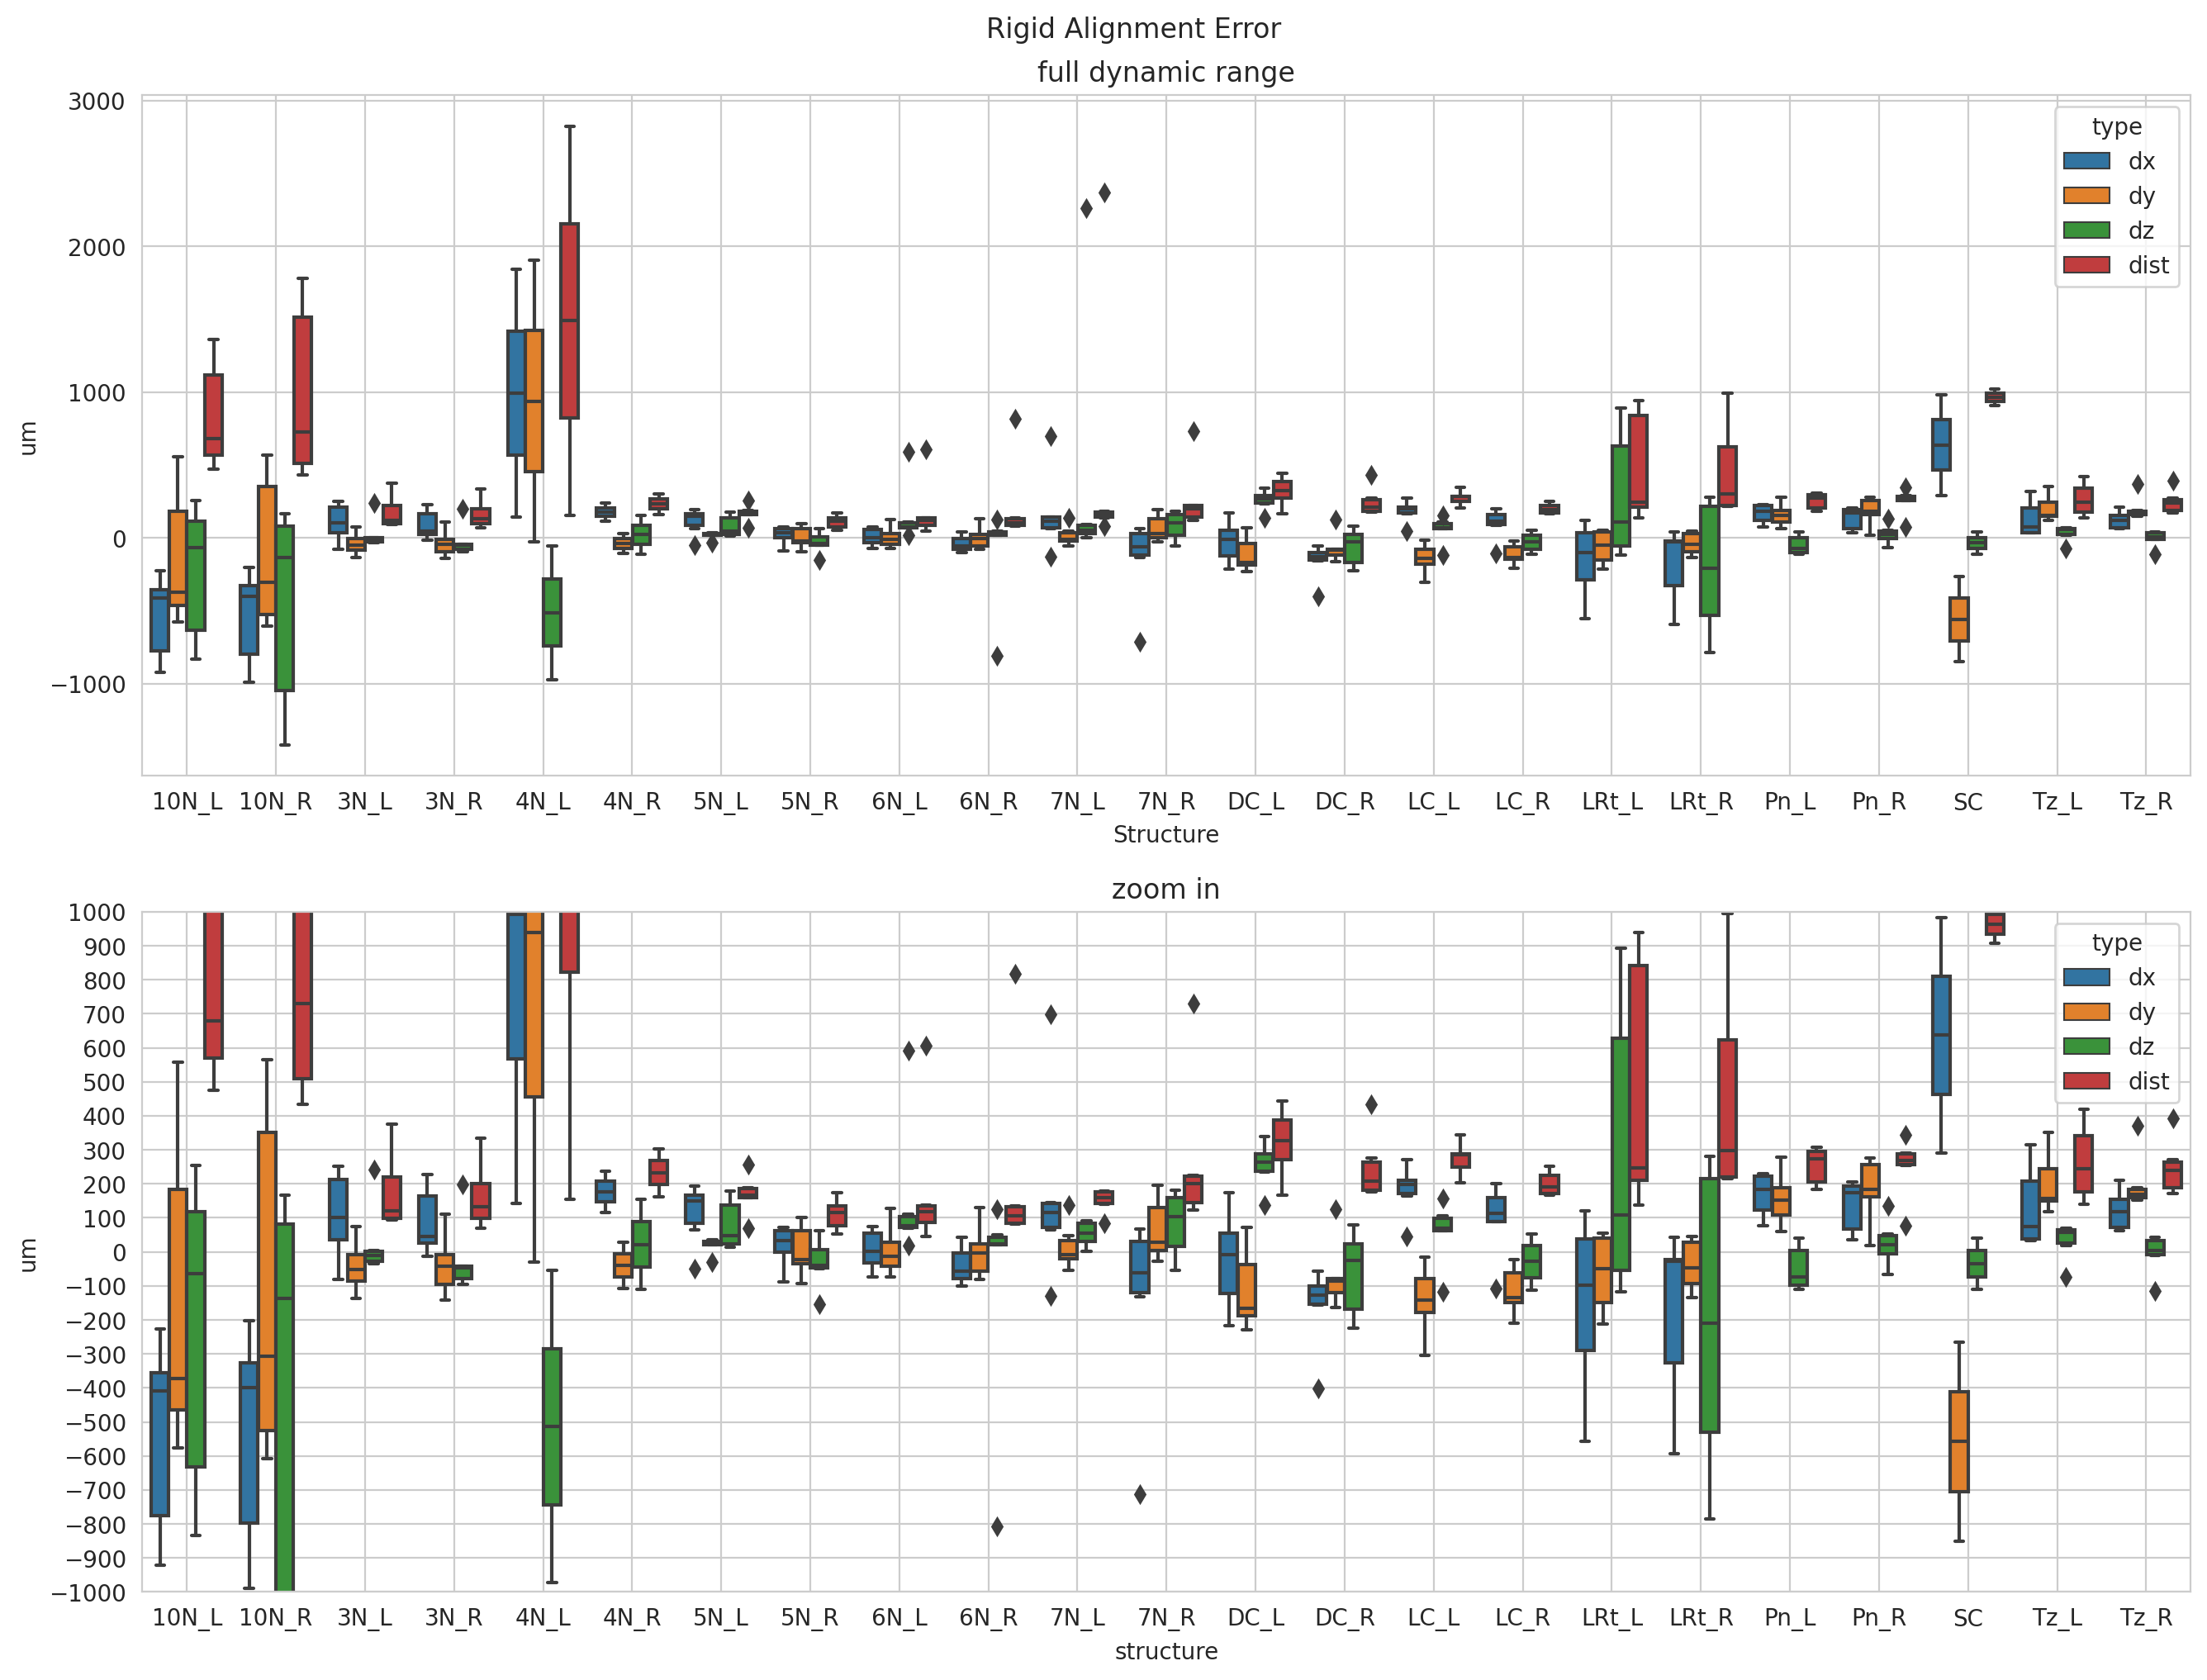

In [9]:
fig = plot(df, -1000, 1000, 100, 'Rigid Alignment Error')
figs.append(fig)

## Rigid Alignment Error After Correction

After reviewing the rigid alignment error plots, Beth manually re-annotatted the significant outliers as a correction. With this updated data, we compute the alignment error again using the same method.

In [10]:
# person is bili, input_type is corrected
df_save, df = prepare_table(
    brains_to_examine,
    person_id=28,
    input_type_id=2,
    save_path='../data/rigid-alignment-error-after-correction.csv'
)
df_save.head()

,name,DK39,DK41,DK43,DK52,DK54,DK55
0,10N_L_dx,-240.390000,-223.260000,-829.93000,-289.970000,-214.860000,-376.260000
1,10N_L_dy,-258.426000,-342.526000,-1.46600,-327.406000,-357.226000,-440.396000
2,10N_L_dz,-93.224000,-29.724000,159.73600,-13.284000,-5.184000,253.496000
3,10N_L_dist,365.050769,409.942196,845.16362,437.554287,416.895801,632.281936
4,10N_R_dx,-183.780000,-125.350000,-856.03000,-266.000000,-254.910000,-988.280000


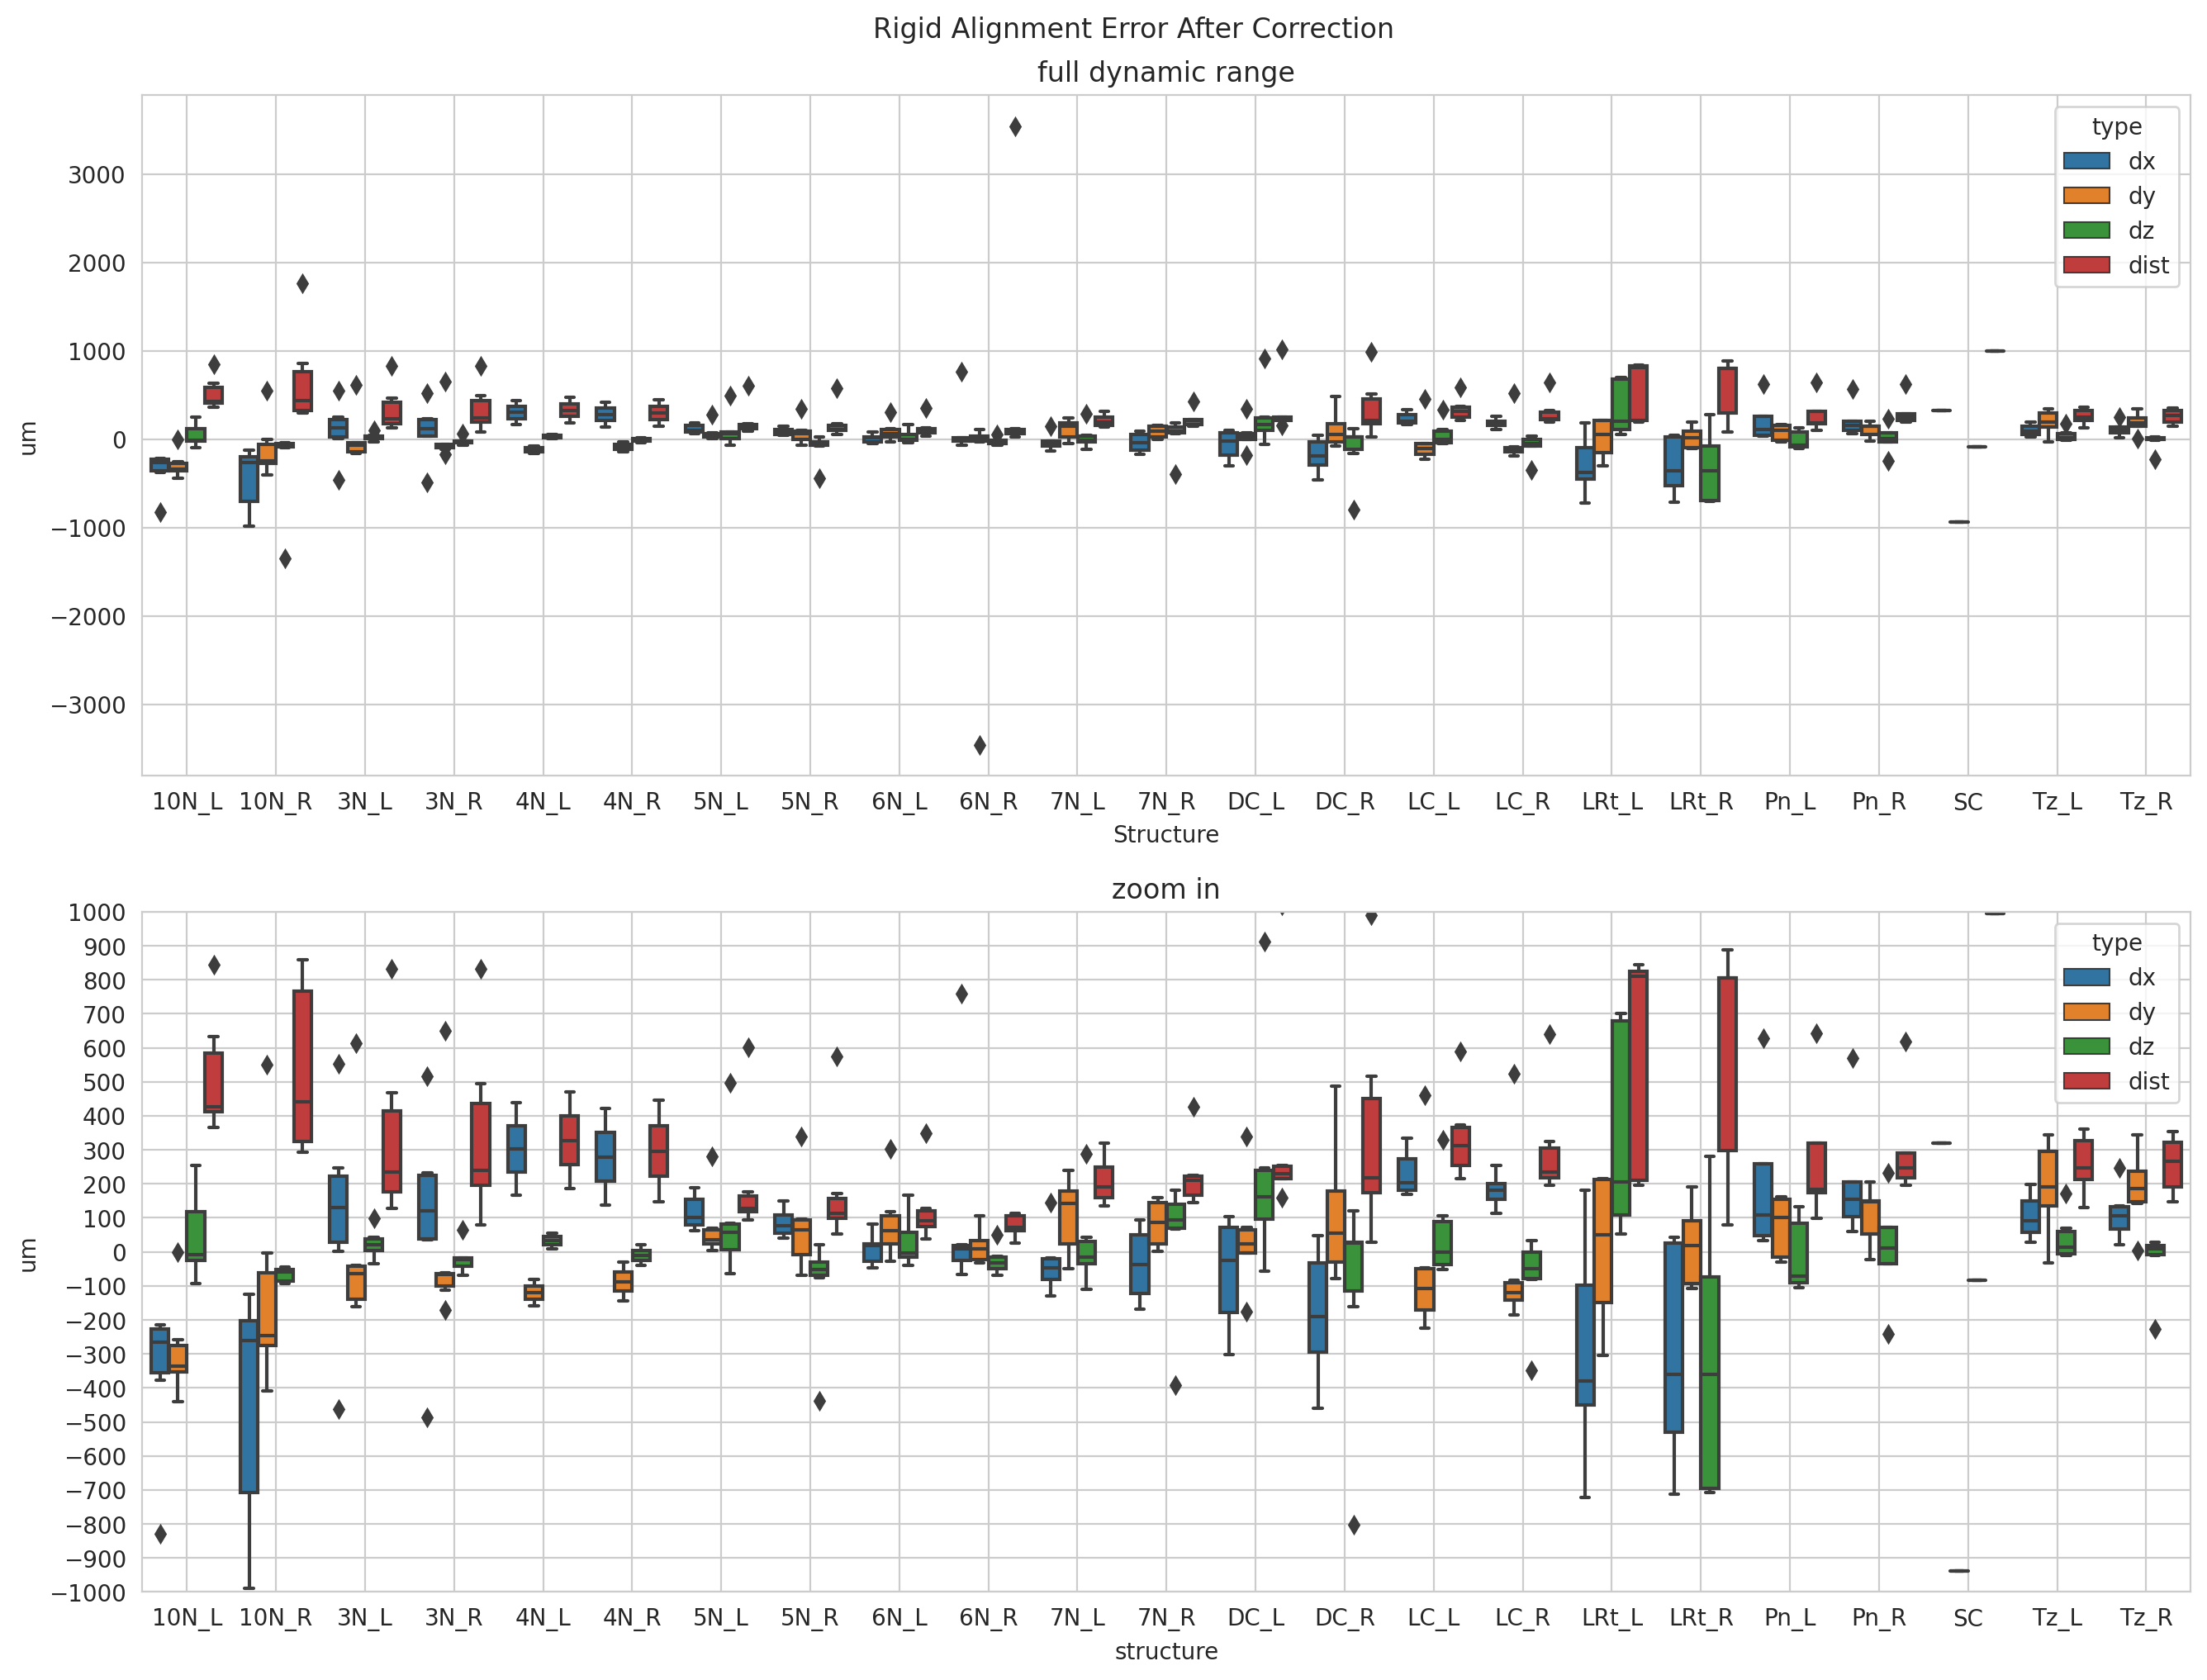

In [11]:
fig = plot(df, -1000, 1000, 100, 'Rigid Alignment Error After Correction')
figs.append(fig)

## Rough Alignment Error

**Rough alignment** is an **automatic method** to find the best 3D affine transformation between 2 brains, solely based on the thumbnail-resolution gray value images. Rough alignment is planned to be the first step of an automatic pipeline, which defines the starting points for Kui's automatic detection method.

We start with an anotomist manually annotate the COMs extensively for one brain (DK52).

Rough alignment error is computed as follows:
1. Computer finds the best 3D affine transformation between DK52 and the brain, as determined by aligning the gray value images.
2. Using the transformation, the DK52 COMs are brought to that brain's space. And we call it the **rough COMs** of the brain.
3. Computer finds the best transformation between atlas COMs and **rough COMs**. The transformation is restricted to rigid + uniform scaling.
4. Using the transformation, the **rough COMs** are brought to the atlas space.
5. The errors between the 2 sets of COMs are calculated, and displayed in the following plots.

The errors for a single structure are quantified by 4 numbers: dx, dy, dz, dist. (dx, dy, dz) are the offset. dist is the corresponding distance of the offset.

In [12]:
# person is ed, input_type is aligned
df_save, df = prepare_table(
    brains_to_examine,
    person_id=1,
    input_type_id=4,
    save_path='../data/rough-alignment-error.csv'
)
df_save.head()

,name,DK39,DK41,DK43,DK52,DK54,DK55
0,10N_L_dx,-348.050000,212.630000,-648.20000,NaN,-418.430000,NaN
1,10N_L_dy,-1940.336000,-1430.836000,-1635.79600,NaN,-1034.106000,NaN
2,10N_L_dz,-412.664000,470.656000,-155.58400,NaN,19.436000,NaN
3,10N_L_dist,2014.034303,1521.190404,1766.40827,NaN,1115.722475,NaN
4,10N_R_dx,712.030000,515.200000,-132.22000,NaN,22.640000,NaN


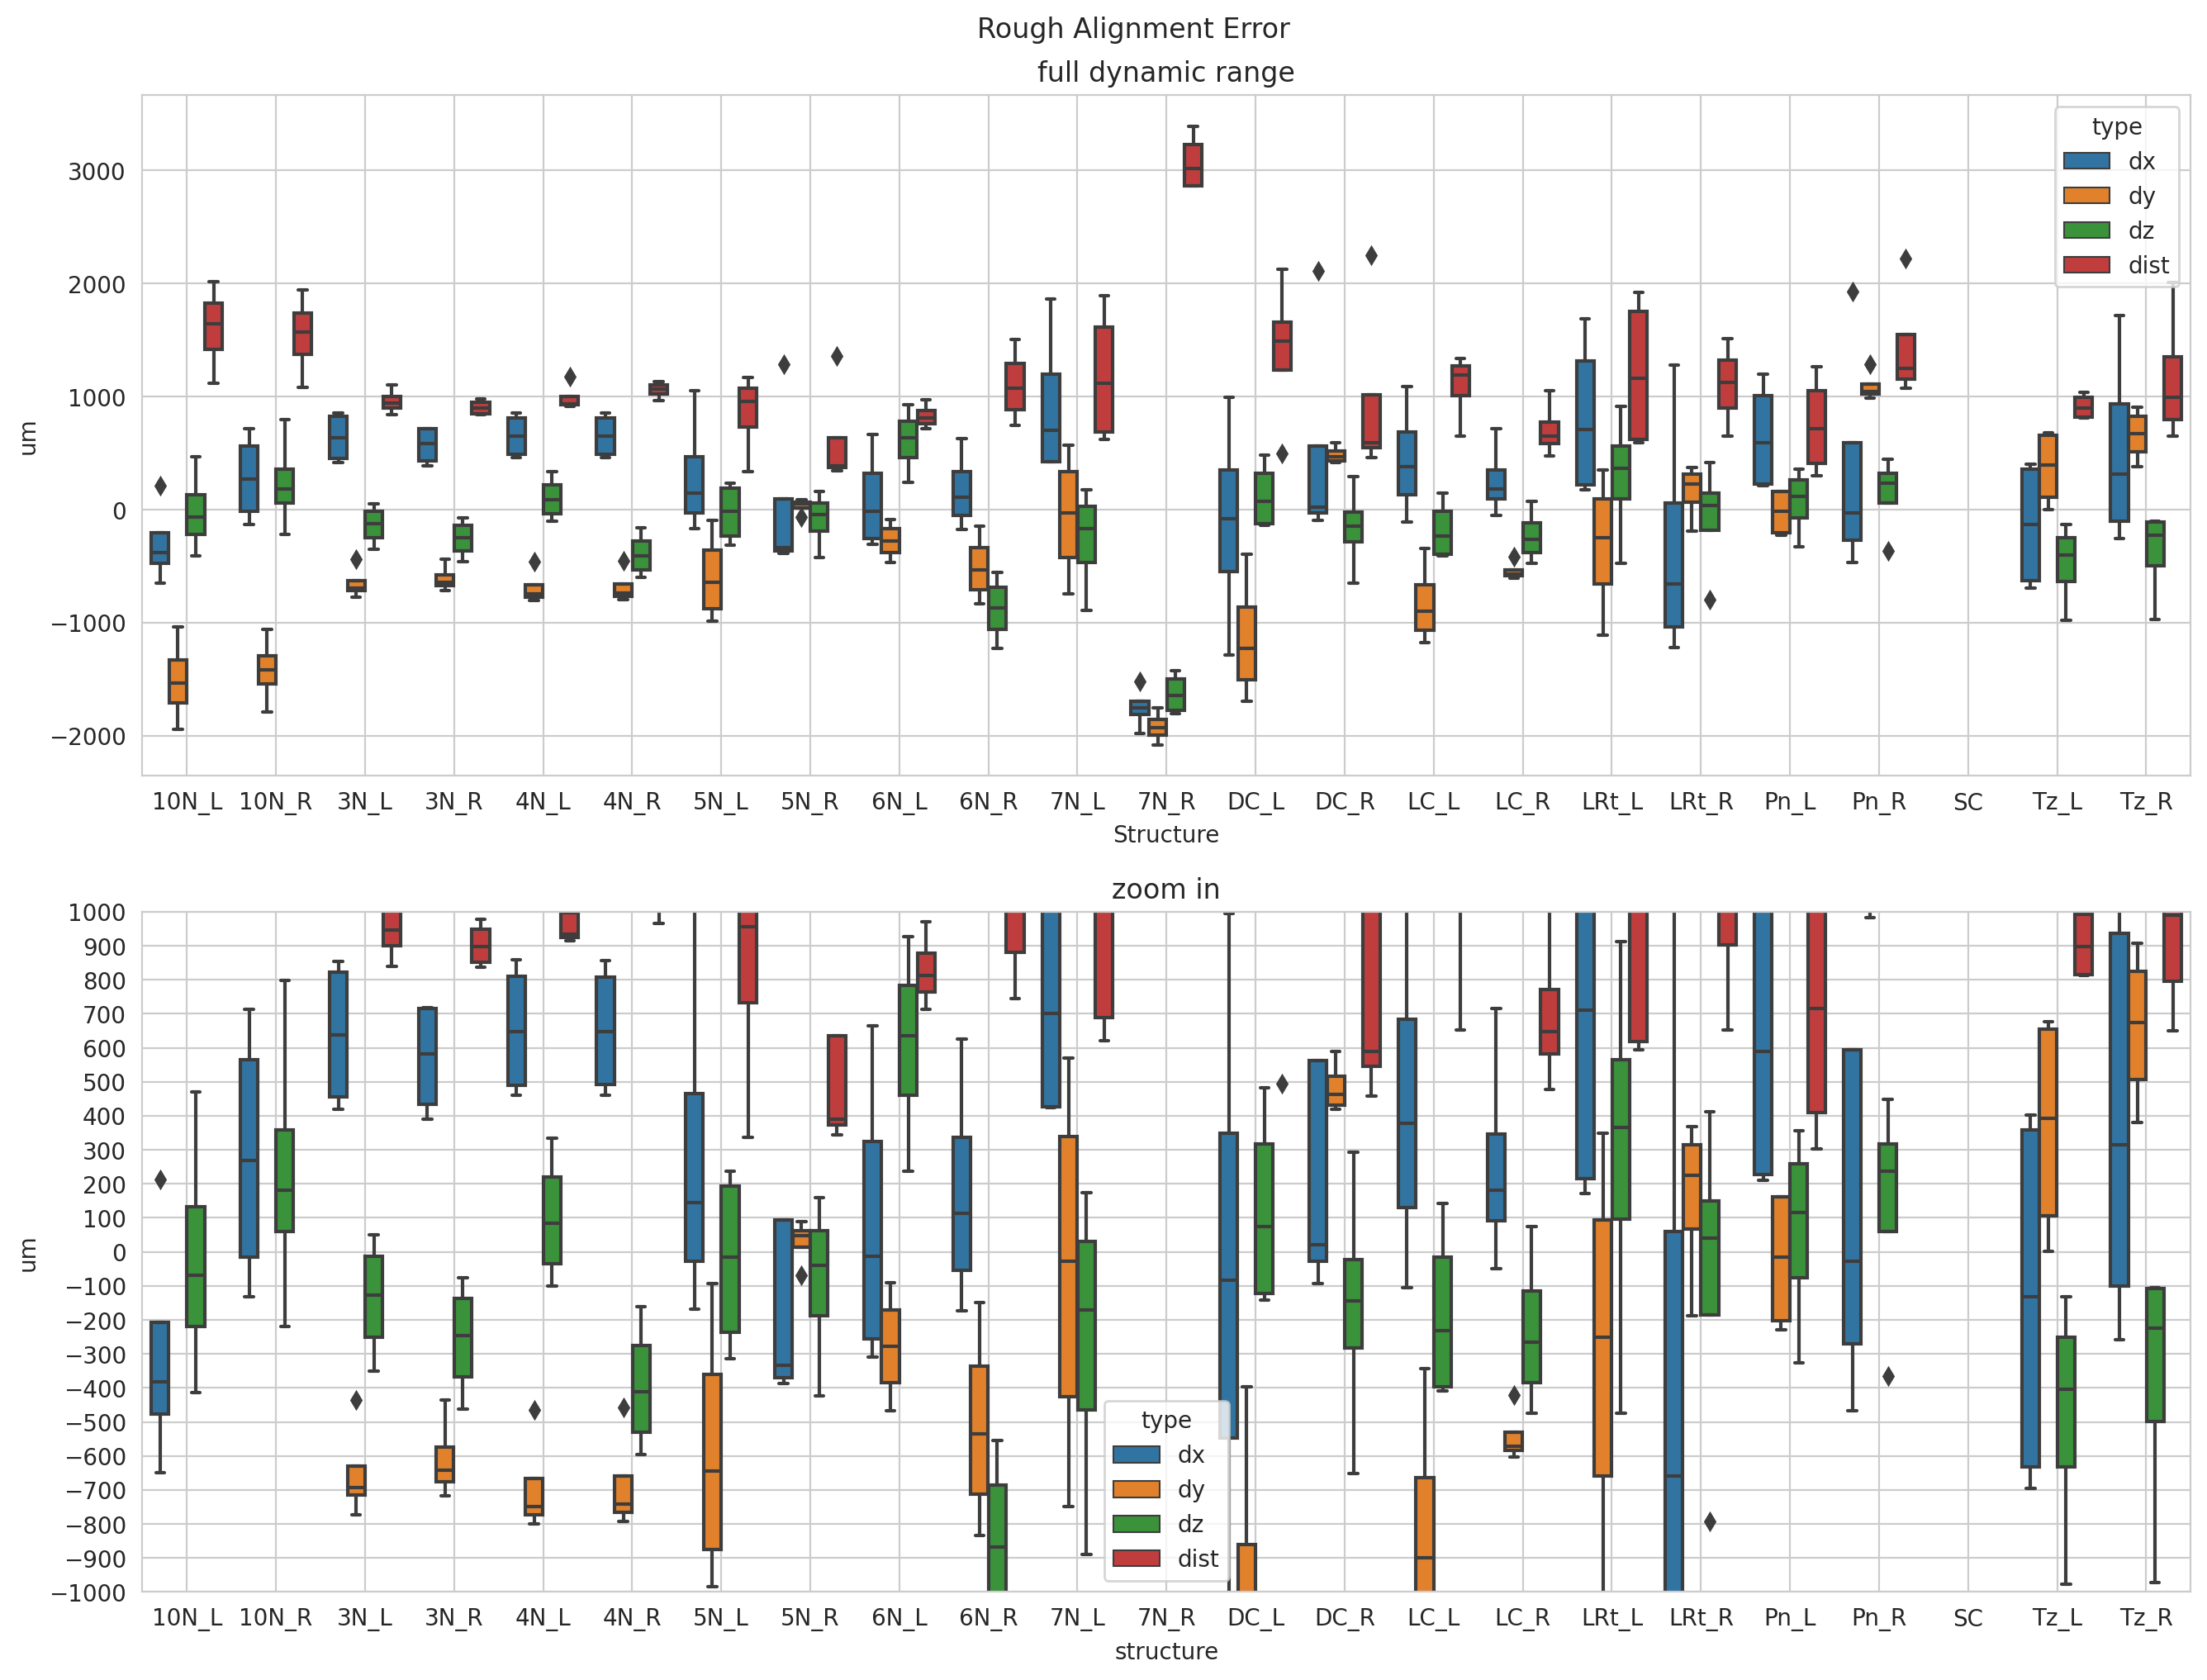

In [13]:
fig = plot(df, -1000, 1000, 100, 'Rough Alignment Error')
figs.append(fig)

## Generate Report

In [14]:
with PdfPages('../data/alignment-error.pdf') as pdf:
    for fig in figs:
        pdf.savefig(fig)